# Libraries

In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk

#Import paths and patients classes
from notebooks.info import path_label

In [2]:
#Valid patients in the dataset
pat_list = [x for x in range(1,46) if x not in [1, 6, 10, 13, 17, 18, 19, 22, 23, 27, 30, 32]] #list of valid patients

# Funtions and classes

## Metadata creation

In [3]:
def get_PathsAndNums():
    """Returns files and patient numbers, NOT sorted

    Returns:
        2 lists: files and numbers lists
    """
    #Get paths  
    folder_path = str(repo_path) + '/data/images/SET'
    p = Path(folder_path).glob('**/*')
    files = [x.relative_to(repo_path) for x in p if x.is_file()]
    #Get patient number
    p = Path(folder_path).glob('**/*')
    pat_num = [int(str(x.relative_to(repo_path).name)[4:6].replace('_','')) for x in p if x.is_file()] #Get patient number
    
    return files, pat_num

def get_PathsAndNums_seg(radiologist, time, stype):
    """Returns files and patient numbers, NOT sorted

    Returns:
        2 lists: files and numbers lists
    """
    #Get paths  
    folder_path = str(repo_path) + f'/data/segmentations/{radiologist}_{time}_seg'
    p = Path(folder_path).glob(f'*_{stype}_{radiologist}.seg.nrrd')
    files = [x.relative_to(repo_path) for x in p if x.is_file()]
    #Get patient number
    p = Path(folder_path).glob(f'*_{stype}_{radiologist}.seg.nrrd')
    pat_num = [int(str(x.relative_to(repo_path).name)[:2].replace('_','')) for x in p if x.is_file()] #Get patient number
    
    return files, pat_num

def get_pathsAndNums_preSet(sequence, t = 't1'):
    folder_path = str(repo_path) + f'/data/images/pre-SET'
    p = Path(folder_path).glob(f'*_{sequence}.tif') if sequence == 'SMC' else Path(folder_path).glob(f'*_{sequence}_{t}.tif')
    files = [x.relative_to(repo_path) for x in p if x.is_file()]
    #Get patient number
    p = Path(folder_path).glob(f'*_{sequence}.tif') if sequence == 'SMC' else Path(folder_path).glob(f'*_{sequence}_{t}.tif')
    pat_num = [int(str(x.relative_to(repo_path).name)[4:6].replace('_','')) for x in p if x.is_file()] #Get patient number
    
    return files, pat_num
    

def info_SET_dataframe(pat_list):
    """returns dataframe with metadata

    Returns:
        _type_: _description_
    """
    #image dataframe
    df = pd.DataFrame() #Save paths in df
    paths_list, pat_nums = get_PathsAndNums() #Not sorted paths and nums
    paths = pd.DataFrame({ #save in frame
        'path_SET': paths_list, 
        'pat_num': pat_nums
    })
    paths = paths.sort_values('pat_num') #Sort paths by alphabetic order
    df = pd.concat([df,paths], ignore_index=True) #Concatenate with previous info
    
    df = df[df['pat_num'].isin(pat_list)].reset_index(drop=True) #Filter by patient list
    
    return df

# def get_labelsAndNums():
#     labels_csv=pd.read_csv(repo_path / 'data/extra_info/labels.csv', sep=',')
#     return labels_csv

In [4]:

def add_segColumns(df, radiologist, time, stype):
    """get dataframe with column of segmentation paths added

    Args:
        df (dataframe): input dataframe
        radiologist (str): radiologist first letter
        time (srt): first or second time (1,2)
        stype (srt): General (G) or focal (F)

    Returns:
        dataframe: output dataframe
    """
    paths_list, pat_nums = get_PathsAndNums_seg(radiologist, time, stype)
    column_name = f'{radiologist}_{time}_{stype}'
    paths = pd.DataFrame({ #save in frame
        column_name: paths_list, 
        'pat_num': pat_nums
    })
    paths = paths.sort_values('pat_num') #Sort paths by alphabetic order
    
    paths = paths[paths['pat_num'].isin(pat_list)].reset_index(drop=True) #Filter by patient list
    df[column_name] = paths[column_name] #add to main df
    
    return df

def add_preSETColumns(df, sequence, t='t1'):
    """get dataframe adding the column of the pre-set sequence

    Args:
        df (dataframe): input dataframe
        sequence (str): contrast or no contrast image
        t (str): tim of the CMC sequenced

    Returns:
        dataframe: output dataframe
    """
    paths_list, pat_nums = get_pathsAndNums_preSet(sequence, t)
    column_name = 'path_SMC' if sequence=='SMC' else f'path_CMC_{t}'
    paths = pd.DataFrame({
        column_name: paths_list,
        'pat_num': pat_nums
    })
    paths = paths.sort_values('pat_num') #Sort paths by alphabetic order
    paths = paths[paths['pat_num'].isin(pat_list)].reset_index(drop=True) #Filter by patient list
    df[column_name] = paths[column_name] #add to main df
    
    return df

In [5]:
def get_metadata(pat_list, save = False):
    """Go thorugh all radiologists, times and ROI type to get all metadata

    Args:
        pat_list (_type_): _description_

    Returns:
        _type_: _description_
    """
    #Get SET images paths and pat num
    df = info_SET_dataframe(pat_list)
    
    #Add segmentation paths to dataframe
    for radiologist in ['L', 'V', 'M']:
        for time in ['1', '2']:
            for stype in ['G', 'F']:
                df = add_segColumns(df, radiologist, time, stype)
    
    #Add pre-SET paths to dataframe
    for sequence in ['SMC', 'CMC']:
        for t in ['t1', 't2', 't3', 't4']:
            if sequence=='SMC': break #Not need to make loop if SMC
            df = add_preSETColumns(df, sequence, t)
        df = add_preSETColumns(df, sequence)
    
    #add labels
    
    #Save metadata as csv
    df.to_csv(str(repo_path) + '/data/metadata.csv', index=False) if save else None
    
    return df

# Metadata creation

## Get metadata
From the list of permissable patients

In [7]:
# Calling the metadata function
meta = get_metadata(pat_list, save = True)

## Testing classes for accesing information using meta

In [ ]:
#Access to general info of the whole dataset
info = path_label()
paths = info.im_path(sequence='SMC')
paths

['data/images/pre-SET/Pat_02_RCC_SMC.tif',
 'data/images/pre-SET/Pat_03_LCC_SMC.tif',
 'data/images/pre-SET/Pat_04_LCC_SMC.tif',
 'data/images/pre-SET/Pat_05_RCC_SMC.tif',
 'data/images/pre-SET/Pat_07_RCC_SMC.tif',
 'data/images/pre-SET/Pat_08_LCC_SMC.tif',
 'data/images/pre-SET/Pat_09_RCC_SMC.tif',
 'data/images/pre-SET/Pat_11_LCC_SMC.tif',
 'data/images/pre-SET/Pat_12_LCC_SMC.tif',
 'data/images/pre-SET/Pat_14_RCC_SMC.tif',
 'data/images/pre-SET/Pat_15_LCC_SMC.tif',
 'data/images/pre-SET/Pat_16_RCC_SMC.tif',
 'data/images/pre-SET/Pat_20_LCC_SMC.tif',
 'data/images/pre-SET/Pat_21_LCC_SMC.tif',
 'data/images/pre-SET/Pat_24_LCC_SMC.tif',
 'data/images/pre-SET/Pat_25_LCC_SMC.tif',
 'data/images/pre-SET/Pat_26_LCC_SMC.tif',
 'data/images/pre-SET/Pat_28_RCC_SMC.tif',
 'data/images/pre-SET/Pat_29_LCC_SMC.tif',
 'data/images/pre-SET/Pat_31_LCC_SMC.tif',
 'data/images/pre-SET/Pat_33_LCC_SMC.tif',
 'data/images/pre-SET/Pat_34_RCC_SMC.tif',
 'data/images/pre-SET/Pat_35_LCC_SMC.tif',
 'data/imag

In [ ]:
#examples of how to access the segmentation
seg_paths = info.seg_path('L', '2', 'F')
print(seg_paths)
print(len(seg_paths))

['data/segmentations/L_2_seg/2_F_L.seg.nrrd', 'data/segmentations/L_2_seg/3_F_L.seg.nrrd', 'data/segmentations/L_2_seg/4_F_L.seg.nrrd', 'data/segmentations/L_2_seg/5_F_L.seg.nrrd', 'data/segmentations/L_2_seg/7_F_L.seg.nrrd', 'data/segmentations/L_2_seg/8_F_L.seg.nrrd', 'data/segmentations/L_2_seg/9_F_L.seg.nrrd', 'data/segmentations/L_2_seg/11_F_L.seg.nrrd', 'data/segmentations/L_2_seg/12_F_L.seg.nrrd', 'data/segmentations/L_2_seg/14_F_L.seg.nrrd', 'data/segmentations/L_2_seg/15_F_L.seg.nrrd', 'data/segmentations/L_2_seg/16_F_L.seg.nrrd', 'data/segmentations/L_2_seg/20_F_L.seg.nrrd', 'data/segmentations/L_2_seg/21_F_L.seg.nrrd', 'data/segmentations/L_2_seg/24_F_L.seg.nrrd', 'data/segmentations/L_2_seg/25_F_L.seg.nrrd', 'data/segmentations/L_2_seg/26_F_L.seg.nrrd', 'data/segmentations/L_2_seg/28_F_L.seg.nrrd', 'data/segmentations/L_2_seg/29_F_L.seg.nrrd', 'data/segmentations/L_2_seg/31_F_L.seg.nrrd', 'data/segmentations/L_2_seg/33_F_L.seg.nrrd', 'data/segmentations/L_2_seg/34_F_L.seg.n

## Visualize

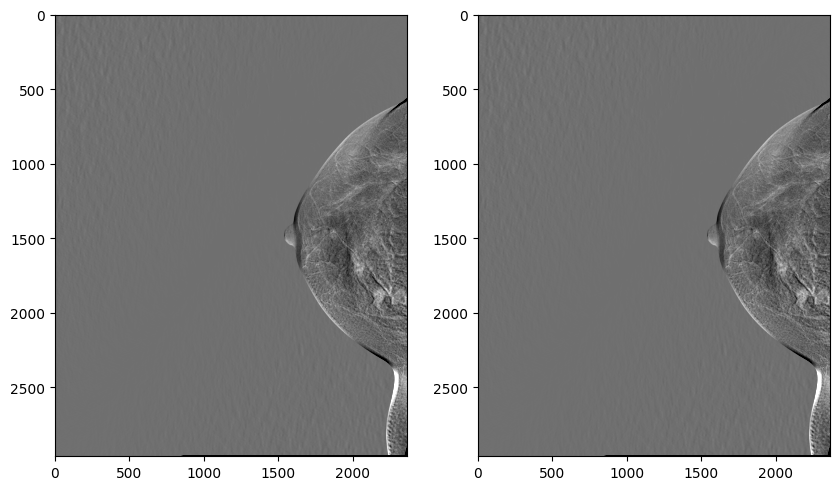

In [ ]:
im_path = str(repo_path /  info.im_path(sequence='SET')[0])
#read tiff image
im = sitk.ReadImage(im_path)
#convert to numpy array
im_array = sitk.GetArrayFromImage(im)
#show images
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(im_array, vmin = 32671, vmax =32893, cmap='gray')
axs[1].imshow(im_array, vmin = 32671, vmax =32893, cmap='gray')

# Add label to the data

Remember:
- HER2 is considered positive for values HER2>0.2

In [10]:
# first read the raw labels
file_path = repo_path / 'data/images/labels/raw_labels.csv'
# read csv
raw_labels = pd.read_csv(file_path, sep=',')
# take only pat_num that are in the pat_list
raw_labels = raw_labels[raw_labels['pat_num'].isin(pat_list)].reset_index(drop=True)
# transform NEGATIVO to 0 and POSITIVO to 1 in all columns
raw_labels = raw_labels.replace({'NEGATIVO': 0, 'POSITIVO': 1})
# transform ki67 column to int dtype
raw_labels['KI67'] = raw_labels['KI67'].astype(float)
# in the KI67 column, put 1 if the value is > 0.2 and 0 otherwise
raw_labels['KI67'] = raw_labels['KI67'].apply(lambda x: 1 if x > 0.2 else 0)
# change 'INDETERMINADO 2+' to 0
raw_labels = raw_labels.replace({'INDETERMINADO 2+': 2})

In [11]:
# add the labels to the metadata without the pat_num column
meta = pd.read_csv(repo_path / 'data/metadata.csv')
raw_labels = raw_labels.drop(columns=['pat_num'])
meta = pd.concat([meta, raw_labels], axis=1)
# overwrite the metadata file
meta.to_csv(repo_path / 'data/metadata.csv', index=False)